# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
from ilqr.examples.cartpole import CartpoleDynamics

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
dt = 0.05
dynamics = CartpoleDynamics(dt)

In [7]:
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([0.0, 0.0, 0.0, 0.0]))

# Instantenous state cost.
Q = 100 * np.eye(dynamics.state_size)
Q[1, 1] = Q[4, 4] = 10.0

# Terminal state cost.
Q_terminal = 100 * np.eye(dynamics.state_size)

# Instantaneous control cost.
R = np.array([[1.0]])

cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
N = 500
x0 = dynamics.augment_state(np.array([0.0, 0.0, np.pi, 0.0]))
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [9]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)

iteration 0 accepted 185594.27177684038 [-0.2579578   0.08224466  1.17540071 -3.29094937]
iteration 1 accepted 185085.862698774 [-0.09652321  0.13242842  1.0627651  -3.5269399 ]
iteration 2 accepted 185061.00003162556 [-0.22792477  0.06727128  1.16354055 -3.29979941]
iteration 3 accepted 184587.93323287772 [-0.10149617  0.15384126  1.07999585 -3.51829774]
iteration 4 accepted 184361.61631309154 [-0.18681377  0.12251365  1.17347672 -3.31343574]
iteration 5 accepted 184098.79718031816 [-0.06725283  0.18298741  1.1017903  -3.53226809]
iteration 6 accepted 183927.84907203526 [-0.19438579  0.1058171   1.18858695 -3.35435207]
iteration 7 accepted 183696.45896049505 [-0.12366663  0.13636838  1.1277764  -3.5593703 ]
iteration 8 accepted 183511.53227071735 [-0.20049945  0.10518929  1.2175414  -3.40145652]
iteration 9 accepted 183273.1790404788 [-0.10227157  0.15875676  1.15371039 -3.61515777]
iteration 10 accepted 183126.42695808882 [-0.19866935  0.10308604  1.24443843 -3.46242115]
iteration 11

In [10]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [11]:
t = np.arange(N + 1) * dt
x = xs[:, 0]
x_dot = xs[:, 1]
theta = np.unwrap(xs[:, 2])  # Makes for smoother plots.
theta_dot = xs[:, 3]

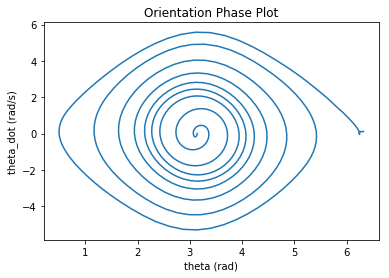

In [12]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

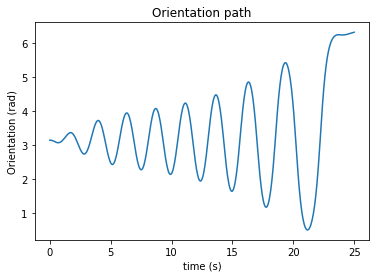

In [13]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

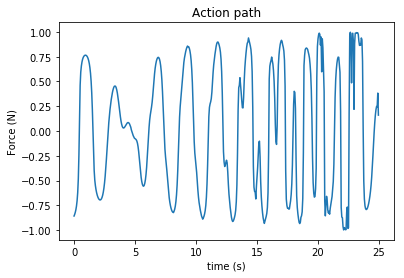

In [14]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

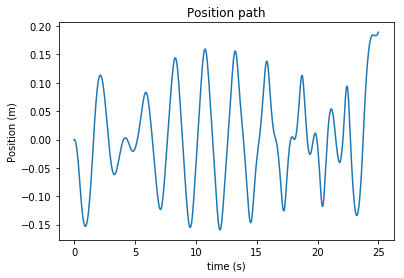

In [15]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

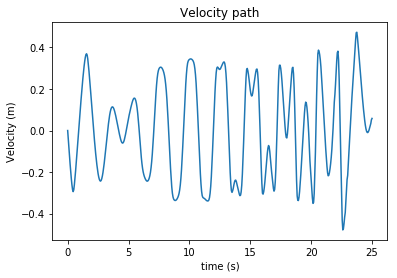

In [16]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

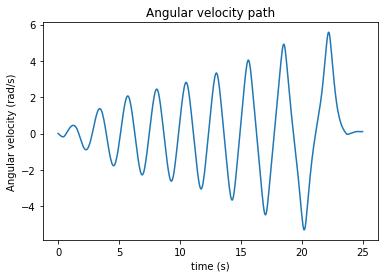

In [17]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

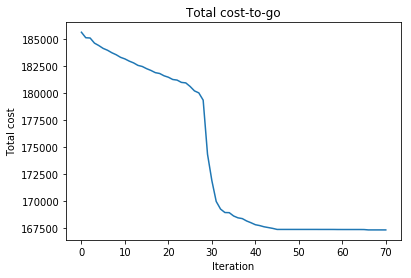

In [18]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")